In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [23]:
import cv2
import numpy as np

def preprocess_palm_image(
    img_bgr,
    IMG_SIZE=128,
    min_area_ratio=0.15
):
    """
    Robust palm preprocessing for CNN training
    """

    if img_bgr is None:
        return None

    h_img, w_img = img_bgr.shape[:2]

    # --------------------------------------------------
    # 1. Convert to Grayscale
    # --------------------------------------------------
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # --------------------------------------------------
    # 2. Noise Reduction (Gaussian Blur)
    # --------------------------------------------------
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # --------------------------------------------------
    # 3. Otsu Threshold (Hand vs Background)
    # --------------------------------------------------
    _, thresh = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Ensure hand is white
    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    # --------------------------------------------------
    # 4. Morphological Cleaning
    # --------------------------------------------------
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    clean = cv2.morphologyEx(clean, cv2.MORPH_OPEN, kernel, iterations=2)

    # --------------------------------------------------
    # 5. Contour Detection
    # --------------------------------------------------
    contours, _ = cv2.findContours(
        clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        return None

    largest = max(contours, key=cv2.contourArea)
    area_ratio = cv2.contourArea(largest) / (h_img * w_img)

    # Reject bad detections
    if area_ratio < min_area_ratio:
        return None

    x, y, w, h = cv2.boundingRect(largest)
    hand_roi = gray[y:y+h, x:x+w]

    # --------------------------------------------------
    # 6. Central Palm ROI (Remove wrist & fingers)
    # --------------------------------------------------
    roi_h, roi_w = hand_roi.shape
    cx, cy = roi_w // 2, roi_h // 2
    palm_size = int(min(roi_w, roi_h) * 0.55)

    x1 = max(cx - palm_size // 2, 0)
    y1 = max(cy - palm_size // 2, 0)
    x2 = min(cx + palm_size // 2, roi_w)
    y2 = min(cy + palm_size // 2, roi_h)

    palm_roi = hand_roi[y1:y2, x1:x2]

    # --------------------------------------------------
    # 7. CLAHE Enhancement (Palm Lines)
    # --------------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(palm_roi)

    # --------------------------------------------------
    # 8. Resize & Normalize
    # --------------------------------------------------
    resized = cv2.resize(enhanced, (IMG_SIZE, IMG_SIZE))
    normalized = resized.astype("float32") / 255.0

    return normalized.reshape(IMG_SIZE, IMG_SIZE, 1)


In [24]:
def debug_preprocessing(img_bgr):
    stages = {}

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    hand = gray[y:y+h, x:x+w]

    h2, w2 = hand.shape
    cx, cy = w2 // 2, h2 // 2
    size = int(min(w2, h2) * 0.55)
    palm = hand[cy-size//2:cy+size//2, cx-size//2:cx+size//2]

    clahe = cv2.createCLAHE(2.0, (8,8))
    enhanced = clahe.apply(palm)

    stages = {
        "Grayscale": gray,
        "Blur": blur,
        "Threshold": thresh,
        "Clean Mask": clean,
        "Hand ROI": hand,
        "Palm ROI": palm,
        "CLAHE": enhanced
    }

    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 8))
    for i, (k, v) in enumerate(stages.items()):
        plt.subplot(2, 4, i+1)
        plt.imshow(v, cmap="gray")
        plt.title(k)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [25]:
DATASET_PATH = "dataset"


images, labels = [], []
class_names = sorted(os.listdir(DATASET_PATH))

for idx, cls in enumerate(class_names):
    cls_path = os.path.join(DATASET_PATH, cls)

    for img_name in os.listdir(cls_path):
        img = cv2.imread(os.path.join(cls_path, img_name))
        processed = preprocess_palm_image(img)

        if processed is None:
            continue

        images.append(processed)
        labels.append(idx)

images = np.array(images)
labels = to_categorical(labels, num_classes=len(class_names))


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True
)


In [ ]:
model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=25,
    validation_data=(X_test, y_test)
)

In [7]:
# Load & Preprocess Dataset
DATASET_PATH = "dataset"
from pre_pro import PalmPreprocessor
palm_preprocessor = PalmPreprocessor()


images = []
labels = []

class_names = sorted(os.listdir(DATASET_PATH))

for idx, person in enumerate(class_names):
    print(f"\n📁 Processing class: {person}")
    person_path = os.path.join(DATASET_PATH, person)

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)

        img = cv2.imread(img_path)
        processed = palm_preprocessor.preprocess(img)

        if processed is None:
            continue

        images.append(processed)
        labels.append(idx)


cv2.imshow("Processed Palm Image", images[0])
cv2.waitKey(0)
images = np.array(images)
labels = to_categorical(labels, num_classes=len(class_names))



📁 Processing class: person_1

📁 Processing class: person_2

📁 Processing class: person_3

📁 Processing class: person_4


In [ ]:
# import cv2
# import numpy as np
# import os

# DEBUG_DIR = "preprocess_debug"
# os.makedirs(DEBUG_DIR, exist_ok=True)

# def preprocess_palm_image_composite(img, IMG_SIZE=128, save_name="debug"):
#     """
#     Saves a single composite image showing all preprocessing stages.
#     Returns final processed image for model input.
#     """

#     original = img.copy()

#     # 1. HSV skin detection
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     lower_skin = np.array([0, 30, 60], dtype=np.uint8)
#     upper_skin = np.array([20, 150, 255], dtype=np.uint8)
#     skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

#     # Morphology
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)
#     skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)

#     # 2. Contour extraction
#     contours, _ = cv2.findContours(
#         skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#     )

#     if len(contours) == 0:
#         return None

#     largest = max(contours, key=cv2.contourArea)
#     x, y, w, h = cv2.boundingRect(largest)
#     palm_roi = img[y:y+h, x:x+w]

#     # 3. Grayscale + CLAHE
#     gray = cv2.cvtColor(palm_roi, cv2.COLOR_BGR2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced = clahe.apply(gray)

#     # 4. Resize + normalize
#     final = cv2.resize(enhanced, (IMG_SIZE, IMG_SIZE))
#     normalized = final / 255.0

#     # ---------- COMPOSITE IMAGE ----------
#     # Resize all for visualization
#     vis_h = 200
#     original_vis = cv2.resize(original, (vis_h, vis_h))
#     skin_vis = cv2.cvtColor(
#         cv2.resize(skin_mask, (vis_h, vis_h)), cv2.COLOR_GRAY2BGR
#     )
#     roi_vis = cv2.resize(palm_roi, (vis_h, vis_h))
#     enhanced_vis = cv2.cvtColor(
#         cv2.resize(enhanced, (vis_h, vis_h)), cv2.COLOR_GRAY2BGR
#     )
#     final_vis = cv2.cvtColor(
#         cv2.resize(final, (vis_h, vis_h)), cv2.COLOR_GRAY2BGR
#     )

#     composite = np.hstack([
#         original_vis,
#         skin_vis,
#         roi_vis,
#         enhanced_vis,
#         final_vis
#     ])

#     # Add labels
#     labels = ["Original", "Skin Mask", "Palm ROI", "Enhanced", "Final Input"]
#     for i, text in enumerate(labels):
#         cv2.putText(
#             composite,
#             text,
#             (i * vis_h + 10, 20),
#             cv2.FONT_HERSHEY_SIMPLEX,
#             0.6,
#             (0, 255, 0),
#             2
#         )

#     # Save composite
#     save_path = os.path.join(DEBUG_DIR, f"{save_name}.png")
#     cv2.imwrite(save_path, composite)

#     return normalized.reshape(IMG_SIZE, IMG_SIZE, 1)



# person = class_names[0]
# person_path = os.path.join(DATASET_PATH, person)

# img_name = os.listdir(person_path)[0]
# img_path = os.path.join(person_path, img_name)

# img = cv2.imread(img_path)

# _ = preprocess_palm_image_composite(
#     img,
#     IMG_SIZE=IMG_SIZE,
#     save_name=f"{person}_{img_name.split('.')[0]}"
# )

# print("Composite debug image saved in preprocess_debug/")





Composite debug image saved in preprocess_debug/


In [27]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, shuffle=True
)

In [28]:
IMG_SIZE = 128
# CNN Model (From Scratch)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\sudip\OneDrive\Desktop\palm-recognition-csy2082\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# # Train Model
# history = model.fit(
#     X_train, y_train,
#     epochs=20,
#     batch_size=16,
#     validation_split=0.2
# )


model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=25,
    validation_data=(X_test, y_test)
)


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 437ms/step - accuracy: 0.2669 - loss: 1.3863 - val_accuracy: 0.2857 - val_loss: 1.3790
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.2709 - loss: 1.3863 - val_accuracy: 0.2857 - val_loss: 1.3790
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.2709 - loss: 1.3863 - val_accuracy: 0.2857 - val_loss: 1.3790
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.2709 - loss: 1.3863 - val_accuracy: 0.2857 - val_loss: 1.3790
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.2709 - loss: 1.3863 - val_accuracy: 0.2857 - val_loss: 1.3790
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.2709 - loss: 1.3862 - val_accuracy: 0.2857 - val_loss: 1.3790
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - accuracy: 0.2709 - loss: 1.3862 - val_accuracy: 0.2857 - val_loss: 1.3791
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - accuracy: 0.2709 - loss: 1.3862 - val_accuracy: 0

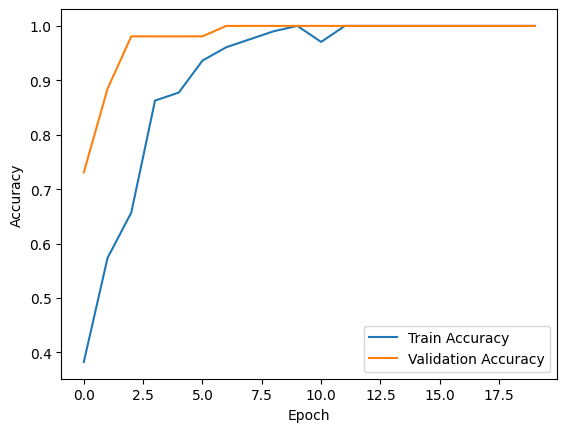

In [12]:
# Training Accuracy Graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [13]:
# Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 1.0000 - loss: 0.0018  
Test Accuracy: 1.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
[[20  0  0  0]
 [ 0 12  0  0]
 [ 0  0 20  0]
 [ 0  0  0 12]]
              precision    recall  f1-score   support

    person_1       1.00      1.00      1.00        20
    person_2       1.00      1.00      1.00        12
    person_3       1.00      1.00      1.00        20
    person_4       1.00      1.00      1.00        12

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



In [14]:
# from tensorflow.keras.models import Model

# embedding_model = Model(
#     inputs=model.input,
#     outputs=model.layers[-2].output  # Dense(128)
# )


from tensorflow.keras.models import Model

embedding_model = Model(
    inputs=model.layers[0].input,  # Get input directly from the first layer
    outputs=model.layers[-2].output  # Dense(128)
)

In [15]:
import pickle

reference_embeddings = {}
EMBEDDING_THRESHOLD = 1.2

for person in class_names:
    embeddings = []
    person_path = os.path.join(DATASET_PATH, person)

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

        emb = embedding_model.predict(img)[0]
        embeddings.append(emb)

    reference_embeddings[person] = np.mean(embeddings, axis=0)

with open("reference_embeddings.pkl", "wb") as f:
    pickle.dump(reference_embeddings, f)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1

In [16]:
# Save Model
model.save("palm_recognition_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


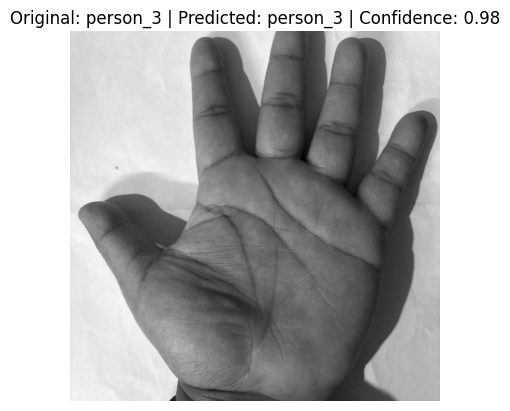

In [22]:
# Random Image Prediction Test

import random
import matplotlib.pyplot as plt

# Confidence threshold for unknown detection
CONFIDENCE_THRESHOLD = 0.6

# Pick random class
true_label = random.choice(class_names)
class_path = os.path.join(DATASET_PATH, true_label)

# Pick random image from that class
img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

# Load and preprocess image
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))
img_norm = img_resized / 255.0
img_input = img_norm.reshape(1, IMG_SIZE, IMG_SIZE, 1)

# Predict
predictions = model.predict(img_input)[0]
confidence = np.max(predictions)
predicted_index = np.argmax(predictions)

# Apply unknown logic
if confidence < CONFIDENCE_THRESHOLD:
    predicted_label = "Unknown"
else:
    predicted_label = class_names[predicted_index]

# Display results
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title(
    f"Original: {true_label} | Predicted: {predicted_label} | Confidence: {confidence:.2f}"
)
plt.show()
